In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from Performance import performance_evaluation
perfs = performance_evaluation()

from Performance import H2h_Regret_Evaluation
h2h_regret_eva = H2h_Regret_Evaluation()

from Data import Data_Simulator
DS_Obj = Data_Simulator()

from Oracle import Oracle_Processing
Oracle_Proc = Oracle_Processing()

from OLS import OLS_Processing
OLS_Proc = OLS_Processing()

from DDR import DDR_Processing
DDR_Proc = DDR_Processing()

from PYEPO import EPO_Processing
PYEPO_Proc = EPO_Processing()

from Data_Load_Store import Load_Store_Methods
Data_LSM = Load_Store_Methods()

In [2]:
def run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        cost_Oracle_Post_all,cost_Oracle_Ante_all = Oracle_Proc.Implement_Oracle(arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,\
                                                                    iteration_all,num_feat,data_generation_process)
        
        cost_OLS_Post_all,cost_OLS_Ante_all = OLS_Proc.Implement_OLS(arcs, grid,mis,bump,\
                                                            W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                            iteration_all,num_feat,data_generation_process)

        cost_DDR_Post_all,cost_DDR_Ante_all = DDR_Proc.Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                                        iteration_all,num_feat,data_generation_process)

        Data_LSM.store_Oracle_OLS_DDR_Cost(DataPath,cost_Oracle_Post_all,cost_Oracle_Ante_all,\
                                  cost_OLS_Post_all,cost_OLS_Ante_all,\
                                  cost_DDR_Post_all,cost_DDR_Ante_all)

In [533]:
def run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        batch_size = 20
        num_epochs = 1000
        # from PYEPO import PyEPO_Method
        # epo_runner = PyEPO_Method()
        # method_names = ["spo+"]
        cost_EPO_Post_all,cost_EPO_Ante_all = PYEPO_Proc.Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,\
                                                    W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                                                    arcs,grid,perfs,num_feat,mis,data_generation_process)

        with open(DataPath+'cost_'+method_names[0]+'_Post_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Post_all,tf)
        with open(DataPath+'cost_'+method_names[0]+'_Ante_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Ante_all,tf)

### Parameters

In [6]:
grid = (3,3) # grid size
from Network import network_design
Network = network_design()
arcs,arc_index_mapping = Network._getArcs(grid)

num_test = 1000
lower = 0 # coef lower bound
upper = 1 # coef upper bound
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

In [8]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))
DataPath_Parent = project_directory + '/Data_JOC_R1/Shortest_Path/Various_Settings_' + data_generation_process + f'/{grid[0]}by{grid[1]}_grid/'
pathlib.Path(DataPath_Parent).mkdir(parents=True, exist_ok=True)
print("DataPath_parent:", DataPath_Parent)

DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/


In [22]:
Result_dir = DataPath_Parent + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

#### Impact of sample size

In [9]:
num_feat = 5 # size of feature
p = num_feat
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
iteration_all = np.arange(0,100)
batch_size = 20
num_epochs = 1000
num_train_all = [50,100,200,500,1000]
mu_all = np.round(np.arange(0.7,0.95,0.05),4)
lamb_all = np.round(np.arange(0.5,0.85,0.05),4)
for num_train in num_train_all:
    DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    print("DataPath:", DataPath)
    
    x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = \
    DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

    Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=50_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=200_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=500_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_S

In [12]:
for num_train in num_train_all:
    DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)
    run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=50_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Oracle: iter= 20 ,cost_Oracle_Ante= 15.200104903979533
Oracle: iter= 40 ,cost_Oracle_Ante= 14.596885929404289
Oracle: iter= 60 ,cost_Oracle_Ante= 15.026113920699338
Oracle: iter= 80 ,cost_Oracle_Ante= 14.899560511015855
OLS: iter= 20 ,cost_OLS_Ante= 15.542637096531974
OLS: iter= 40 ,cost_OLS_Ante= 14.775261817049653
OLS: iter= 60 ,cost_OLS_Ante= 15.161339987933882
OLS: iter= 80 ,cost_OLS_Ante= 15.594084285435885
DDR: iter= 20 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.547223922426335
DDR: iter= 40 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 14.776121304772587
DDR: iter= 60 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.156175649483023
DDR: iter= 80 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.5737308

In [358]:
num_feat = 5 # size of feature
p = num_feat
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
iteration_all = np.arange(0,100)
batch_size = 20
num_epochs = 1000
num_train_all = [50,100,200,500,1000]
for num_train in num_train_all:
    DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)
    method_names = ["spo+"]
    run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=50_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 16.244893892552973
['spo+'] : iter= 40 ,cost_EPO_Ante= 16.428055532274975
['spo+'] : iter= 60 ,cost_EPO_Ante= 15.981433882029382
['spo+'] : iter= 80 ,cost_EPO_Ante= 15.859118474945745
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 16.417801861458877
['spo+'] : iter= 40 ,cost_EPO_Ante= 16.17762456340405
['spo+'] : iter= 60 ,cost_EPO_Ante= 15.520834399445182
['spo+'] : iter= 80 ,cost_EPO_Ante= 16.005682898751196
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings

In [13]:
regret_N_ante_Dict = {}; h2h_N_ante_Dict = {}
for mu in mu_all:
    for lamb in lamb_all:
        regret_N_ante = np.zeros(len(num_train_all)); h2h_N_ante = np.zeros(len(num_train_all))
        _index = 0
        for num_train in num_train_all:
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print(DataPath)
            
            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            # with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
            #     cost_SPO_Ante_all = pickle.load(tf)
            h2h_N_ante[_index], regret_N_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_N_ante_Dict[mu,lamb] = regret_N_ante
        h2h_N_ante_Dict[mu,lamb] = h2h_N_ante

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=50_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=200_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=500_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=10

In [24]:
with open(Result_dir+'regret_N_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_N_ante_Dict,tf)
with open(Result_dir+'h2h_N_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_N_ante_Dict,tf)

In [359]:
regret_DDR_vs_SPO_N_ante_Dict = {}; h2h_DDR_vs_SPO_N_ante_Dict = {}
for mu in mu_all:
    for lamb in lamb_all:
        regret_N_ante = np.zeros(len(num_train_all)); h2h_N_ante = np.zeros(len(num_train_all))
        _index = 0
        for num_train in num_train_all:
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print(DataPath)
            
            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
                cost_SPO_Ante_all = pickle.load(tf)
            h2h_N_ante[_index], regret_N_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        h2h_DDR_vs_SPO_N_ante_Dict[mu,lamb] = regret_N_ante
        regret_DDR_vs_SPO_N_ante_Dict[mu,lamb] = h2h_N_ante
with open(Result_dir+'regret_DDR_vs_SPO_N_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_DDR_vs_SPO_N_ante_Dict,tf)
with open(Result_dir+'h2h_DDR_vs_SPO_N_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_DDR_vs_SPO_N_ante_Dict,tf)

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=50_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=200_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=500_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=10

#### Impact of number of feature

In [25]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
num_train = 100
num_feat_all = [1,3,5,7,10,15]
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)

        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=1_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=3_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=7_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=10_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various

In [26]:
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)        
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=1_num_test=1000_x_dist=uniform_e_dist=normal/
Oracle: iter= 20 ,cost_Oracle_Ante= 15.257637842298115
Oracle: iter= 40 ,cost_Oracle_Ante= 14.725700366736161
Oracle: iter= 60 ,cost_Oracle_Ante= 15.22940579974066
Oracle: iter= 80 ,cost_Oracle_Ante= 15.239774025144223
OLS: iter= 20 ,cost_OLS_Ante= 15.302365123597683
OLS: iter= 40 ,cost_OLS_Ante= 14.736042798945851
OLS: iter= 60 ,cost_OLS_Ante= 15.42639212291927
OLS: iter= 80 ,cost_OLS_Ante= 15.292864513530068
DDR: iter= 20 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.304311468197541
DDR: iter= 40 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 14.736042798945851
DDR: iter= 60 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.422975041411904
DDR: iter= 80 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.291515656732056
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_

In [416]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
num_train = 100
num_feat_all = [1,3,5,7,10,15]
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)    
        run_EPO_approaches(DataPath,["spo+"],arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=1_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 15.295603036867758
['spo+'] : iter= 40 ,cost_EPO_Ante= 15.527104034050273
['spo+'] : iter= 60 ,cost_EPO_Ante= 16.757083545918512
['spo+'] : iter= 80 ,cost_EPO_Ante= 15.256121596639924
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=3_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 15.422479963761802
['spo+'] : iter= 40 ,cost_EPO_Ante= 16.187306886790733
['spo+'] : iter= 60 ,cost_EPO_Ante= 16.011881846505222
['spo+'] : iter= 80 ,cost_EPO_Ante= 15.82003731700877
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Setting

In [27]:
regret_P_ante_Dict = {}; h2h_P_ante_Dict = {}
for mu in mu_all:
    for lamb in lamb_all:
        regret_P_ante = np.zeros(len(num_feat_all)); h2h_P_ante = np.zeros(len(num_feat_all))
        _index = 0
        for num_feat in num_feat_all:
            p = num_feat
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print("DataPath:", DataPath)        

            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            
            h2h_P_ante[_index], regret_P_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_P_ante_Dict[mu,lamb] = regret_P_ante
        h2h_P_ante_Dict[mu,lamb] = h2h_P_ante
with open(Result_dir+'regret_P_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_P_ante_Dict,tf)
with open(Result_dir+'h2h_P_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_P_ante_Dict,tf)
# Save the regret and h2h regret results

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=1_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=3_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=7_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_

In [417]:
regret_DDR_vs_SPO_P_ante_Dict = {}; h2h_DDR_vs_SPO_P_ante_Dict = {}
for mu in mu_all:
    for lamb in lamb_all:
        regret_P_ante = np.zeros(len(num_feat_all)); h2h_P_ante = np.zeros(len(num_feat_all))
        _index = 0
        for num_feat in num_feat_all:
            p = num_feat
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print("DataPath:", DataPath)        

            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
                cost_SPO_Ante_all = pickle.load(tf)
            h2h_P_ante[_index], regret_P_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_DDR_vs_SPO_P_ante_Dict[mu,lamb] = regret_P_ante
        h2h_DDR_vs_SPO_P_ante_Dict[mu,lamb] = h2h_P_ante
with open(Result_dir+'regret_DDR_vs_SPO_P_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_DDR_vs_SPO_P_ante_Dict,tf)
with open(Result_dir+'h2h_DDR_vs_SPO_P_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_DDR_vs_SPO_P_ante_Dict,tf)
# Save the regret and h2h regret results

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=1_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=3_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=7_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_

#### Impact of alpha

In [28]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
num_train = 100
num_feat = 5
p = num_feat
e_all = [0.25,0.5,0.75,1.0]
for e in e_all:
    alpha = e # scale of normal std or the range of uniform. For the error term
    if e != 0.5:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)
        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.25_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.75_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=1.0_p=5_num_test=1000_x_dist=uniform_e_dist=normal/


In [29]:
for e in e_all:
    alpha = e 
    if e != 0.5:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        print("DataPath:", DataPath)
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.25_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
Oracle: iter= 20 ,cost_Oracle_Ante= 15.172642031123184
Oracle: iter= 40 ,cost_Oracle_Ante= 14.600967169194192
Oracle: iter= 60 ,cost_Oracle_Ante= 15.016002191297218
Oracle: iter= 80 ,cost_Oracle_Ante= 14.89354010044007
OLS: iter= 20 ,cost_OLS_Ante= 15.235883205968085
OLS: iter= 40 ,cost_OLS_Ante= 14.617245664800324
OLS: iter= 60 ,cost_OLS_Ante= 15.049181318205603
OLS: iter= 80 ,cost_OLS_Ante= 14.928611363318609
DDR: iter= 20 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.231792321634133
DDR: iter= 40 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 14.616868850338355
DDR: iter= 60 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 15.050291854356344
DDR: iter= 80 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 14.930647301538789
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JO

In [436]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
num_train = 100
num_feat = 5
p = num_feat
e_all = [0.25,0.5,0.75,1.0]
for e in e_all:
    alpha = e 
    if e != 0.5:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        print("DataPath:", DataPath)
        run_EPO_approaches(DataPath,["spo+"],arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.25_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 15.94743242241657
['spo+'] : iter= 40 ,cost_EPO_Ante= 15.070208014216659
['spo+'] : iter= 60 ,cost_EPO_Ante= 15.40445003407734
['spo+'] : iter= 80 ,cost_EPO_Ante= 15.830810940930103
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.75_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 15.77651258814573
['spo+'] : iter= 40 ,cost_EPO_Ante= 14.973345993515817
['spo+'] : iter= 60 ,cost_EPO_Ante= 15.8673299258841
['spo+'] : iter= 80 ,cost_EPO_Ante= 16.042810129459728
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_

In [34]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
num_train = 100
num_feat = 5
p = num_feat
e_all = [0.25,0.5,0.75,1.0]
regret_e_ante_Dict = {}; h2h_e_ante_Dict = {}
for mu in mu_all:
    for lamb in lamb_all:
        regret_e_ante = np.zeros(len(e_all)); h2h_e_ante = np.zeros(len(e_all))
        _index = 0
        for e in e_all:
            alpha = e 
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print("DataPath:", DataPath)

            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            
            h2h_e_ante[_index], regret_e_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_e_ante_Dict[mu,lamb] = regret_e_ante
        h2h_e_ante_Dict[mu,lamb] = h2h_e_ante
with open(Result_dir+'regret_e_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_e_ante_Dict,tf)
with open(Result_dir+'h2h_e_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_e_ante_Dict,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.25_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.75_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=1.0_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Variou

In [437]:
regret_DDR_vs_SPO_e_ante_Dict = {}; h2h_DDR_vs_SPO_e_ante_Dict = {}
for mu in mu_all:
    for lamb in lamb_all:
        regret_e_ante = np.zeros(len(e_all)); h2h_e_ante = np.zeros(len(e_all))
        _index = 0
        for e in e_all:
            alpha = e 
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print("DataPath:", DataPath)

            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
                cost_SPO_Ante_all = pickle.load(tf)
            h2h_e_ante[_index], regret_e_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_DDR_vs_SPO_e_ante_Dict[mu,lamb] = regret_e_ante
        h2h_DDR_vs_SPO_e_ante_Dict[mu,lamb] = h2h_e_ante
with open(Result_dir+'regret_DDR_vs_SPO_e_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_DDR_vs_SPO_e_ante_Dict,tf)
with open(Result_dir+'h2h_DDR_vs_SPO_e_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_DDR_vs_SPO_e_ante_Dict,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.25_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.75_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=1.0_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Variou

#### Impact of model misspecification

In [31]:
e = 0.5
alpha = e
num_train = 100
num_feat = 5
p = num_feat
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0,4.0]
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)

        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.4_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.6_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.8_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.2_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_

In [32]:
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        print("DataPath:", DataPath)
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.4_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
Oracle: iter= 20 ,cost_Oracle_Ante= 9.974746843194604
Oracle: iter= 40 ,cost_Oracle_Ante= 9.856448226220069
Oracle: iter= 60 ,cost_Oracle_Ante= 9.949329095991978
Oracle: iter= 80 ,cost_Oracle_Ante= 9.918527311495193
OLS: iter= 20 ,cost_OLS_Ante= 10.066202257534798
OLS: iter= 40 ,cost_OLS_Ante= 9.91609848122351
OLS: iter= 60 ,cost_OLS_Ante= 10.014275543903883
OLS: iter= 80 ,cost_OLS_Ante= 10.07851624680234
DDR: iter= 20 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 10.066129823264038
DDR: iter= 40 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 9.915228009964421
DDR: iter= 60 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 10.016941095087015
DDR: iter= 80 ,mu= 0.9 ,lamb= 0.8 ,cost_DDR_Ante = 10.075905249694296
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Sho

In [446]:
e = 0.5
alpha = e
num_train = 100
num_feat = 5
p = num_feat
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0,4.0]
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
        print("DataPath:", DataPath)
        run_EPO_approaches(DataPath,["spo+"],arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.4_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 10.232252963664047
['spo+'] : iter= 40 ,cost_EPO_Ante= 10.217938323224013
['spo+'] : iter= 60 ,cost_EPO_Ante= 10.18594335470916
['spo+'] : iter= 80 ,cost_EPO_Ante= 10.223517992335406
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.6_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
['spo+'] : iter= 20 ,cost_EPO_Ante= 11.687808610759868
['spo+'] : iter= 40 ,cost_EPO_Ante= 11.672881805323337
['spo+'] : iter= 60 ,cost_EPO_Ante= 11.633707030005029
['spo+'] : iter= 80 ,cost_EPO_Ante= 11.480980202823453
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Setting

In [35]:
e = 0.5
alpha = e
num_train = 100
num_feat = 5
p = num_feat
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0,4.0]
regret_d_ante_Dict = {}; h2h_d_ante_Dict = {}

for mu in mu_all:
    for lamb in lamb_all:
        regret_d_ante = np.zeros(len(deg_all)); h2h_d_ante = np.zeros(len(deg_all))
        _index = 0
        for deg in deg_all:
            mis = deg # model misspecification
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print("DataPath:", DataPath)

            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            
            h2h_d_ante[_index], regret_d_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_d_ante_Dict[mu,lamb] = regret_d_ante
        h2h_d_ante_Dict[mu,lamb] = h2h_d_ante
with open(Result_dir+'regret_d_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_d_ante_Dict,tf)
with open(Result_dir+'h2h_d_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_d_ante_Dict,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.4_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.6_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.8_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_

In [447]:
e = 0.5
alpha = e
num_train = 100
num_feat = 5
p = num_feat
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0,4.0]
regret_DDR_vs_SPO_d_ante_Dict = {}; h2h_DDR_vs_SPO_d_ante_Dict = {}

for mu in mu_all:
    for lamb in lamb_all:
        regret_d_ante = np.zeros(len(deg_all)); h2h_d_ante = np.zeros(len(deg_all))
        _index = 0
        for deg in deg_all:
            mis = deg # model misspecification
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print("DataPath:", DataPath)

            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
                cost_SPO_Ante_all = pickle.load(tf)            
            h2h_d_ante[_index], regret_d_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_DDR_vs_SPO_d_ante_Dict[mu,lamb] = regret_d_ante
        h2h_DDR_vs_SPO_d_ante_Dict[mu,lamb] = h2h_d_ante
with open(Result_dir+'regret_DDR_vs_SPO_d_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_DDR_vs_SPO_d_ante_Dict,tf)
with open(Result_dir+'h2h_DDR_vs_SPO_d_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_DDR_vs_SPO_d_ante_Dict,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.4_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.6_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=0.8_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_

## Figures

### Plot Figure

In [ ]:
Result_dir = DataPath_Parent + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

In [284]:
mu = 0.9
lamb = 0.5
h2h_N_ante = h2h_N_ante_Dict[mu,lamb]
regret_N_ante = regret_N_ante_Dict[mu,lamb]

h2h_P_ante = h2h_P_ante_Dict[mu,lamb]
regret_P_ante = regret_P_ante_Dict[mu,lamb]

h2h_d_ante = h2h_d_ante_Dict[mu,lamb]
regret_d_ante = regret_d_ante_Dict[mu,lamb]

h2h_e_ante = h2h_e_ante_Dict[mu,lamb]
regret_e_ante = regret_e_ante_Dict[mu,lamb]

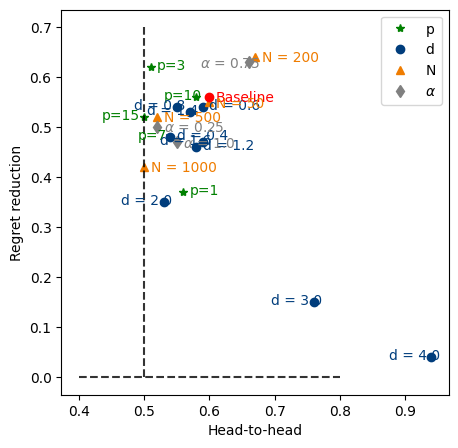

In [272]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
p_indices = [0,1,3,4,5]
plt.plot(h2h_P_ante[p_indices], regret_P_ante[p_indices], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_P_ante[p_indices[0]] + 0.01, regret_P_ante[p_indices[0]] - 0.005, 'p='+str(num_feat_all[p_indices[0]]), color='green')
plt.text(h2h_P_ante[p_indices[1]] + 0.01, regret_P_ante[p_indices[1]] - 0.005, 'p='+str(num_feat_all[p_indices[1]]), color='green')
plt.text(h2h_P_ante[p_indices[2]] - 0.05, regret_P_ante[p_indices[2]] - 0.005, 'p='+str(num_feat_all[p_indices[2]]), color='green')
plt.text(h2h_P_ante[p_indices[3]] - 0.05, regret_P_ante[p_indices[3]] - 0.005, 'p='+str(num_feat_all[p_indices[3]]), color='green')
plt.text(h2h_P_ante[p_indices[4]] - 0.065, regret_P_ante[p_indices[4]] - 0.005, 'p='+str(num_feat_all[p_indices[4]]), color='green')

plt.plot(h2h_d_ante[0], regret_d_ante[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[1], regret_d_ante[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[2], regret_d_ante[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[4], regret_d_ante[4], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[5], regret_d_ante[5], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[6], regret_d_ante[6], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[7], regret_d_ante[7], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[8], regret_d_ante[8], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[9], regret_d_ante[9], color='#003D7C', marker = "o", linestyle = 'None')


plt.text(h2h_d_ante[0] + 0.01, regret_d_ante[0] - 0.005, 'd = '+str(deg_all[0]), color='#003D7C')
# plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d_ante[1] + 0.01, regret_d_ante[1] - 0.005, 'd = '+str(deg_all[1]), color='#003D7C')
plt.text(h2h_d_ante[2] - 0.065, regret_d_ante[2] - 0.005, 'd = '+str(deg_all[2]), color='#003D7C')
plt.text(h2h_d_ante[4] + 0.01, regret_d_ante[4] - 0.005, 'd = '+str(deg_all[4]), color='#003D7C')
plt.text(h2h_d_ante[5] - 0.065, regret_d_ante[5] - 0.005, 'd = '+str(deg_all[5]), color='#003D7C')
plt.text(h2h_d_ante[6] - 0.065, regret_d_ante[6] - 0.005, 'd = '+str(deg_all[6]), color='#003D7C')
plt.text(h2h_d_ante[7] - 0.065, regret_d_ante[7] - 0.005, 'd = '+str(deg_all[7]), color='#003D7C')
plt.text(h2h_d_ante[8] - 0.065, regret_d_ante[8] - 0.005, 'd = '+str(deg_all[8]), color='#003D7C')
plt.text(h2h_d_ante[9] - 0.065, regret_d_ante[9] - 0.005, 'd = '+str(deg_all[9]), color='#003D7C')


plt.plot(h2h_N_ante[0], regret_N_ante[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
plt.text(h2h_N_ante[1] + 0.01, regret_N_ante[1] - 0.01, 'Baseline', color='red')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[2], regret_N_ante[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[3], regret_N_ante[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[4], regret_N_ante[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N_ante[0] + 0.01, regret_N_ante[0] - 0.01, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N_ante[2] + 0.01, regret_N_ante[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_N_ante[3] + 0.01, regret_N_ante[3] - 0.01, 'N = 500', color='#EF7C00')
plt.text(h2h_N_ante[4] + 0.01, regret_N_ante[4] - 0.01, 'N = 1000', color='#EF7C00')


plt.plot(h2h_e_ante[0], regret_e_ante[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e_ante[2], regret_e_ante[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e_ante[3], regret_e_ante[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_e_ante[0] + 0.01, regret_e_ante[0] - 0.01, r'$\alpha$ = 0.25', color='grey')
# plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_e_ante[2] - 0.075, regret_e_ante[2] - 0.01, r'$\alpha$ = 0.75', color='grey')
plt.text(h2h_e_ante[3] + 0.01, regret_e_ante[3] - 0.01, r'$\alpha$ = 1.0', color='grey')

plt.vlines(0.5, 0.0, 0.7, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.0, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker = "o", linestyle = 'None')
# plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath_parent+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_dir +f'DDR_vs_OLS_diff_settings_ante_mu={mu}_lamb={lamb}.pdf', format='pdf', bbox_inches="tight")
plt.show()

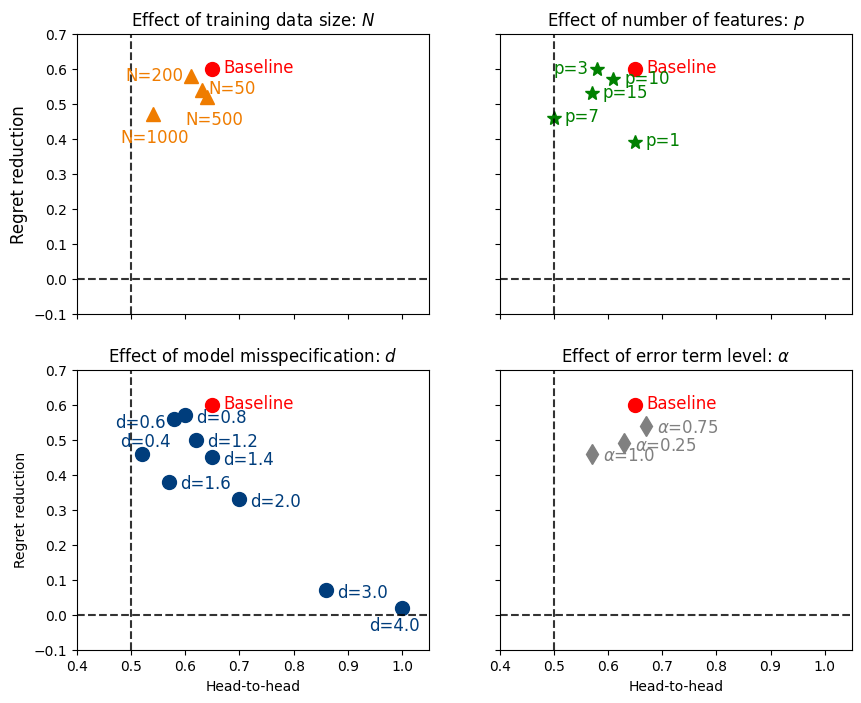

In [285]:
ms = 10 # marker size
fs = 12 # font size
ls = 12 # label size
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# # ---- 子图 1: N 的影响 ----
ax = axes[0]
N_indices = [0, 2, 3, 4]
for i in N_indices:
    ax.plot(h2h_N_ante[i], regret_N_ante[i], color='#EF7C00', marker='^', markersize = ms, linestyle='None')

ax.text(h2h_N_ante[0] + 0.012, regret_N_ante[0] - 0.01, f'N={num_train_all[0]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[2] - 0.12, regret_N_ante[2] - 0.012, f'N={num_train_all[2]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[3] - 0.04, regret_N_ante[3] - 0.08, f'N={num_train_all[3]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[4] - 0.06, regret_N_ante[4] - 0.08, f'N={num_train_all[4]}', color='#EF7C00', fontsize=fs)
# 单独标注 baseline
ax.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_N_ante[1] + 0.02, regret_N_ante[1] - 0.01, 'Baseline', color='red',fontsize=fs)
ax.set_title('Effect of training data size: $N$',fontsize = ls)
ax.set_xlabel('Head-to-head',fontsize=ls)
ax.set_ylabel('Regret reduction',fontsize=ls)
# ax.grid(True)


# ---- 子图 2: p 的影响 ----
ax = axes[1]
p_indices = [0, 1, 3, 4, 5]
ax.plot([h2h_P_ante[i] for i in p_indices], [regret_P_ante[i] for i in p_indices],
        color='green', marker='*',markersize = ms, linestyle='None', label='p')
ax.plot(h2h_P_ante[2], regret_P_ante[2],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_P_ante[2] + 0.02, regret_P_ante[2] - 0.01, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_P_ante[p_indices[0]] + 0.02, regret_P_ante[p_indices[0]] - 0.01, f'p={num_feat_all[p_indices[0]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[1]] - 0.08, regret_P_ante[p_indices[1]] - 0.012, f'p={num_feat_all[p_indices[1]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[2]] + 0.02, regret_P_ante[p_indices[2]] - 0.01, f'p={num_feat_all[p_indices[2]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[3]] + 0.02, regret_P_ante[p_indices[3]] - 0.012, f'p={num_feat_all[p_indices[3]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[4]] + 0.02, regret_P_ante[p_indices[4]] - 0.012, f'p={num_feat_all[p_indices[4]]}', color='green',fontsize = fs)

ax.set_title('Effect of number of features: $p$')
ax.set_xlabel('Head-to-head', fontsize=fs)
ax.set_ylabel('Regret reduction', fontsize=fs)
# ax.grid(True)

# # ---- 子图 3: d 的影响 ----
ax = axes[2]
d_indices = [0, 1, 2, 4, 5, 6, 7, 8, 9]
for i in d_indices:
    ax.plot(h2h_d_ante[i], regret_d_ante[i], color='#003D7C', marker='o', markersize = ms,linestyle='None')
ax.plot(h2h_d_ante[3], regret_d_ante[3],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_d_ante[3] + 0.02, regret_d_ante[3] - 0.01, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_d_ante[0] - 0.04, regret_d_ante[0] + 0.02, f'd={deg_all[0]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[1] - 0.11, regret_d_ante[1] - 0.025, f'd={deg_all[1]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[2] + 0.02, regret_d_ante[2] - 0.02, f'd={deg_all[2]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[4] + 0.02, regret_d_ante[4] - 0.02, f'd={deg_all[4]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[5] + 0.02, regret_d_ante[5] - 0.02, f'd={deg_all[5]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[6] + 0.02, regret_d_ante[6] - 0.02, f'd={deg_all[6]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[7] + 0.02, regret_d_ante[7] - 0.02, f'd={deg_all[7]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[8] + 0.02, regret_d_ante[8] - 0.02, f'd={deg_all[8]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[9] - 0.06, regret_d_ante[9] - 0.065, f'd={deg_all[9]}', color='#003D7C',fontsize=fs)

ax.set_title('Effect of model misspecification: $d$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)



# # ---- 子图 4: α 的影响 ----
ax = axes[3]
alpha_indices = [0, 2, 3]
alpha_vals = [0.25, 0.75, 1.0]
for i, alpha in zip(alpha_indices, alpha_vals):
    ax.plot(h2h_e_ante[i], regret_e_ante[i], color='gray', marker='d', markersize = ms, linestyle='None')
ax.plot(h2h_e_ante[1], regret_e_ante[1],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_e_ante[1] + 0.02, regret_e_ante[1] - 0.01, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_e_ante[0] + 0.02, regret_e_ante[0] - 0.02, rf'$\alpha$={e_all[0]}', color='gray',fontsize = fs)
ax.text(h2h_e_ante[2] + 0.02, regret_e_ante[2] - 0.02, rf'$\alpha$={e_all[2]}', color='gray',fontsize = fs)
ax.text(h2h_e_ante[3] + 0.02, regret_e_ante[3] - 0.02, rf'$\alpha$={e_all[3]}', color='gray',fontsize = fs)

ax.set_title('Effect of error term level: $\\alpha$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)

# ---- 整体设置 ----
for ax in axes:
    ax.axvline(0.5, linestyle='dashed', alpha=0.8, color='k')
    ax.axhline(0.0, linestyle='dashed', alpha=0.8, color='k')
    ax.set_xlim(0.4, 1.05)
    ax.set_ylim(-0.1, 0.7)
    ax.label_outer()

# plt.tight_layout()
fig.savefig(Result_dir + f'DDR_vs_OLS_diff_settings_ante_mu={mu}_lamb={lamb}_subfigures.pdf', format='pdf', bbox_inches="tight")
plt.show()


In [276]:
Result_dir

'/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_SPO_Data_Generation/3by3_grid/Result/'

In [353]:
mu = 0.8
lamb = 0.5
h2h_N_ante = h2h_N_ante_Dict[mu,lamb]
regret_N_ante = regret_N_ante_Dict[mu,lamb]

h2h_P_ante = h2h_P_ante_Dict[mu,lamb]
regret_P_ante = regret_P_ante_Dict[mu,lamb]

h2h_d_ante = h2h_d_ante_Dict[mu,lamb]
regret_d_ante = regret_d_ante_Dict[mu,lamb]

h2h_e_ante = h2h_e_ante_Dict[mu,lamb]
regret_e_ante = regret_e_ante_Dict[mu,lamb]

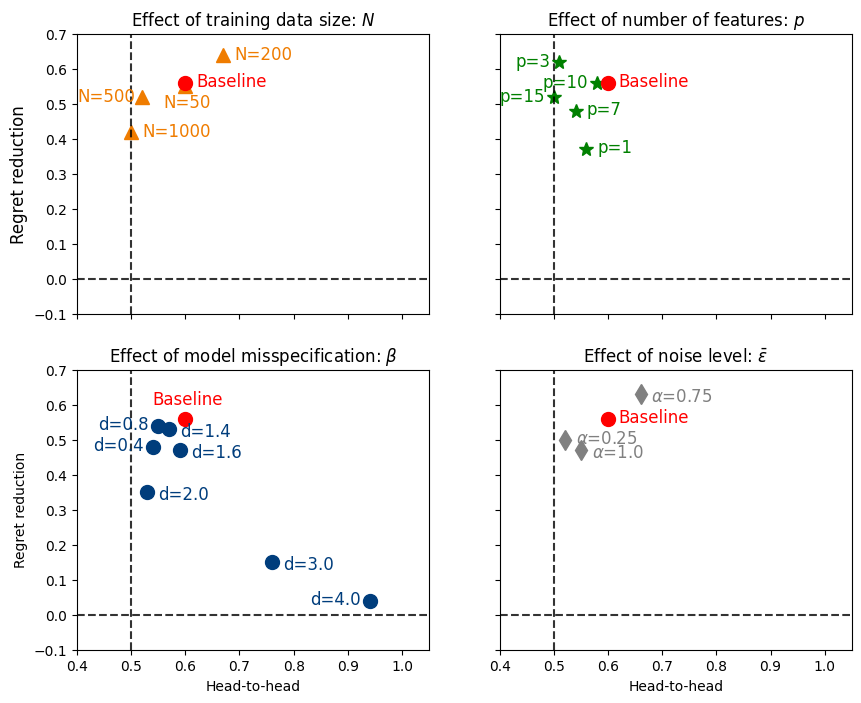

In [354]:
ms = 10 # marker size
fs = 12 # font size
ls = 12 # label size
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# # ---- 子图 1: N 的影响 ----
ax = axes[0]
N_indices = [0, 2, 3, 4]
for i in N_indices:
    ax.plot(h2h_N_ante[i], regret_N_ante[i], color='#EF7C00', marker='^', markersize = ms, linestyle='None')

ax.text(h2h_N_ante[0] - 0.04, regret_N_ante[0] - 0.06, f'N={num_train_all[0]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[2] + 0.02, regret_N_ante[2] - 0.012, f'N={num_train_all[2]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[3] - 0.12, regret_N_ante[3] - 0.012, f'N={num_train_all[3]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[4] + 0.02, regret_N_ante[4] - 0.012, f'N={num_train_all[4]}', color='#EF7C00', fontsize=fs)
# 单独标注 baseline
ax.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_N_ante[1] + 0.02, regret_N_ante[1] - 0.01, 'Baseline', color='red',fontsize=fs)
ax.set_title('Effect of training data size: $N$',fontsize = ls)
ax.set_xlabel('Head-to-head',fontsize=ls)
ax.set_ylabel('Regret reduction',fontsize=ls)
# ax.grid(True)


# ---- 子图 2: p 的影响 ----
ax = axes[1]
p_indices = [0, 1, 3, 4, 5]
ax.plot([h2h_P_ante[i] for i in p_indices], [regret_P_ante[i] for i in p_indices],
        color='green', marker='*',markersize = ms, linestyle='None', label='p')
ax.plot(h2h_P_ante[2], regret_P_ante[2],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_P_ante[2] + 0.02, regret_P_ante[2] - 0.01, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_P_ante[p_indices[0]] + 0.02, regret_P_ante[p_indices[0]] - 0.01, f'p={num_feat_all[p_indices[0]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[1]] - 0.08, regret_P_ante[p_indices[1]] - 0.012, f'p={num_feat_all[p_indices[1]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[2]] + 0.02, regret_P_ante[p_indices[2]] - 0.01, f'p={num_feat_all[p_indices[2]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[3]] - 0.1, regret_P_ante[p_indices[3]] - 0.012, f'p={num_feat_all[p_indices[3]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[4]] - 0.1, regret_P_ante[p_indices[4]] - 0.012, f'p={num_feat_all[p_indices[4]]}', color='green',fontsize = fs)

ax.set_title('Effect of number of features: $p$')
ax.set_xlabel('Head-to-head', fontsize=fs)
ax.set_ylabel('Regret reduction', fontsize=fs)
# ax.grid(True)

# # ---- 子图 3: d 的影响 ----
ax = axes[2]
d_indices = [0, 2, 5, 6, 7, 8, 9]
for i in d_indices:
    ax.plot(h2h_d_ante[i], regret_d_ante[i], color='#003D7C', marker='o', markersize = ms,linestyle='None')
ax.plot(h2h_d_ante[3], regret_d_ante[3],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_d_ante[3] - 0.06, regret_d_ante[3] + 0.04, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_d_ante[0] - 0.11, regret_d_ante[0] - 0.01, f'd={deg_all[0]}', color='#003D7C',fontsize=fs)
# ax.text(h2h_d_ante[1] + 0.02, regret_d_ante[1] - 0.025, f'd={deg_all[1]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[2] - 0.11, regret_d_ante[2] - 0.01, f'd={deg_all[2]}', color='#003D7C',fontsize=fs)
# ax.text(h2h_d_ante[4] + 0.02, regret_d_ante[4] - 0.025, f'd={deg_all[4]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[5] + 0.02, regret_d_ante[5] - 0.02, f'd={deg_all[5]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[6] + 0.02, regret_d_ante[6] - 0.02, f'd={deg_all[6]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[7] + 0.02, regret_d_ante[7] - 0.02, f'd={deg_all[7]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[8] + 0.02, regret_d_ante[8] - 0.02, f'd={deg_all[8]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[9] - 0.11, regret_d_ante[9] - 0.01, f'd={deg_all[9]}', color='#003D7C',fontsize=fs)

ax.set_title('Effect of model misspecification: $\\beta$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)



# # ---- 子图 4: α 的影响 ----
ax = axes[3]
alpha_indices = [0, 2, 3]
alpha_vals = [0.25, 0.75, 1.0]
for i, alpha in zip(alpha_indices, alpha_vals):
    ax.plot(h2h_e_ante[i], regret_e_ante[i], color='gray', marker='d', markersize = ms, linestyle='None')
ax.plot(h2h_e_ante[1], regret_e_ante[1],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_e_ante[1] + 0.02, regret_e_ante[1] - 0.01, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_e_ante[0] + 0.02, regret_e_ante[0] - 0.01, rf'$\alpha$={e_all[0]}', color='gray',fontsize = fs)
ax.text(h2h_e_ante[2] + 0.02, regret_e_ante[2] - 0.02, rf'$\alpha$={e_all[2]}', color='gray',fontsize = fs)
ax.text(h2h_e_ante[3] + 0.02, regret_e_ante[3] - 0.02, rf'$\alpha$={e_all[3]}', color='gray',fontsize = fs)

ax.set_title('Effect of noise level: $\\bar{\epsilon}$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)

# ---- 整体设置 ----
for ax in axes:
    ax.axvline(0.5, linestyle='dashed', alpha=0.8, color='k')
    ax.axhline(0.0, linestyle='dashed', alpha=0.8, color='k')
    ax.set_xlim(0.4, 1.05)
    ax.set_ylim(-0.1, 0.7)
    ax.label_outer()

# plt.tight_layout()
fig.savefig(Result_dir + f'DDR_vs_OLS_diff_settings_ante_mu={mu}_lamb={lamb}_subfigures.pdf', format='pdf', bbox_inches="tight")
plt.show()


In [517]:
mu = 0.75
lamb = 0.8
h2h_N_ante = h2h_N_ante_Dict[mu,lamb]
regret_N_ante = regret_N_ante_Dict[mu,lamb]

h2h_P_ante = h2h_P_ante_Dict[mu,lamb]
regret_P_ante = regret_P_ante_Dict[mu,lamb]

h2h_d_ante = h2h_d_ante_Dict[mu,lamb]
regret_d_ante = regret_d_ante_Dict[mu,lamb]

h2h_e_ante = h2h_e_ante_Dict[mu,lamb]
regret_e_ante = regret_e_ante_Dict[mu,lamb]

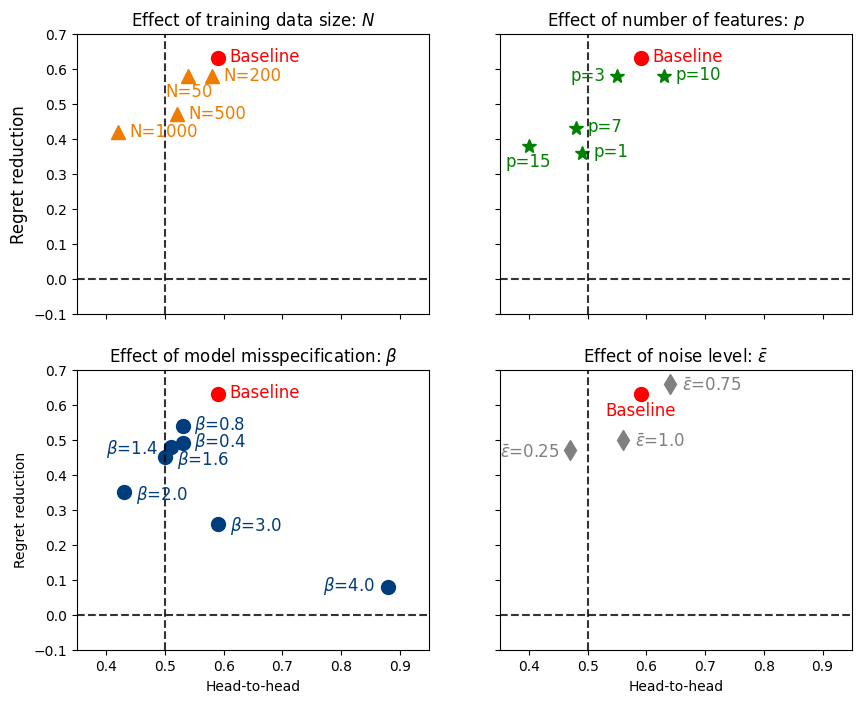

In [531]:
ms = 10 # marker size
fs = 12 # font size
ls = 12 # label size
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# # ---- 子图 1: N 的影响 ----
ax = axes[0]
N_indices = [0, 2, 3, 4]
for i in N_indices:
    ax.plot(h2h_N_ante[i], regret_N_ante[i], color='#EF7C00', marker='^', markersize = ms, linestyle='None')

ax.text(h2h_N_ante[0] - 0.04, regret_N_ante[0] - 0.06, f'N={num_train_all[0]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[2] + 0.02, regret_N_ante[2] - 0.012, f'N={num_train_all[2]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[3] + 0.02, regret_N_ante[3] - 0.012, f'N={num_train_all[3]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[4] + 0.02, regret_N_ante[4] - 0.012, f'N={num_train_all[4]}', color='#EF7C00', fontsize=fs)
# 单独标注 baseline
ax.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_N_ante[1] + 0.02, regret_N_ante[1] - 0.01, 'Baseline', color='red',fontsize=fs)
ax.set_title('Effect of training data size: $N$',fontsize = ls)
ax.set_xlabel('Head-to-head',fontsize=ls)
ax.set_ylabel('Regret reduction',fontsize=ls)
# ax.grid(True)


# ---- 子图 2: p 的影响 ----
ax = axes[1]
p_indices = [0, 1, 3, 4, 5]
ax.plot([h2h_P_ante[i] for i in p_indices], [regret_P_ante[i] for i in p_indices],
        color='green', marker='*',markersize = ms, linestyle='None', label='p')
ax.plot(h2h_P_ante[2], regret_P_ante[2],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_P_ante[2] + 0.02, regret_P_ante[2] - 0.01, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_P_ante[p_indices[0]] + 0.02, regret_P_ante[p_indices[0]] - 0.01, f'p={num_feat_all[p_indices[0]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[1]] - 0.08, regret_P_ante[p_indices[1]] - 0.012, f'p={num_feat_all[p_indices[1]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[2]] + 0.02, regret_P_ante[p_indices[2]] - 0.01, f'p={num_feat_all[p_indices[2]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[3]] + 0.02, regret_P_ante[p_indices[3]] - 0.01, f'p={num_feat_all[p_indices[3]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[4]] - 0.04, regret_P_ante[p_indices[4]] - 0.06, f'p={num_feat_all[p_indices[4]]}', color='green',fontsize = fs)

ax.set_title('Effect of number of features: $p$')
ax.set_xlabel('Head-to-head', fontsize=fs)
ax.set_ylabel('Regret reduction', fontsize=fs)
# ax.grid(True)

# # ---- 子图 3: d 的影响 ----
ax = axes[2]
d_indices = [0, 2, 5, 6, 7, 8, 9]
for i in d_indices:
    ax.plot(h2h_d_ante[i], regret_d_ante[i], color='#003D7C', marker='o', markersize = ms,linestyle='None')
ax.plot(h2h_d_ante[3], regret_d_ante[3],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_d_ante[3] + 0.02, regret_d_ante[3] - 0.01, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_d_ante[0] + 0.02, regret_d_ante[0] - 0.01, f'$\\beta$={deg_all[0]}', color='#003D7C',fontsize=fs)
# # ax.text(h2h_d_ante[1] + 0.02, regret_d_ante[1] - 0.025, f'd={deg_all[1]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[2] + 0.02, regret_d_ante[2] - 0.01, f'$\\beta$={deg_all[2]}', color='#003D7C',fontsize=fs)
# # ax.text(h2h_d_ante[4] + 0.02, regret_d_ante[4] - 0.025, f'd={deg_all[4]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[5] - 0.11, regret_d_ante[5] - 0.02, f'$\\beta$={deg_all[5]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[6] + 0.02, regret_d_ante[6] - 0.02, f'$\\beta$={deg_all[6]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[7] + 0.02, regret_d_ante[7] - 0.02, f'$\\beta$={deg_all[7]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[8] + 0.02, regret_d_ante[8] - 0.02, f'$\\beta$={deg_all[8]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[9] - 0.11, regret_d_ante[9] - 0.01, f'$\\beta$={deg_all[9]}', color='#003D7C',fontsize=fs)

ax.set_title('Effect of model misspecification: $\\beta$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)



# # ---- 子图 4: α 的影响 ----
ax = axes[3]
alpha_indices = [0,2,3]
alpha_vals = [0.25, 0.75, 1.0]
for i, alpha in zip(alpha_indices, alpha_vals):
    ax.plot(h2h_e_ante[i], regret_e_ante[i], color='gray', marker='d', markersize = ms, linestyle='None')
ax.plot(h2h_e_ante[1], regret_e_ante[1],color='red', marker='o', markersize = ms,linestyle='None')
ax.text(h2h_e_ante[1] - 0.06, regret_e_ante[1] - 0.06, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_e_ante[0] - 0.12, regret_e_ante[0] - 0.02, r'$\bar{\epsilon}$=0.25', color='gray',fontsize = fs)
ax.text(h2h_e_ante[2] + 0.02, regret_e_ante[2] - 0.02, r'$\bar{\epsilon}$=0.75', color='gray',fontsize = fs)
ax.text(h2h_e_ante[3] + 0.02, regret_e_ante[3] - 0.02, r'$\bar{\epsilon}$=1.0', color='gray',fontsize = fs)

ax.set_title('Effect of noise level: $\\bar{\epsilon}$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)

# ---- 整体设置 ----
for ax in axes:
    ax.axvline(0.5, linestyle='dashed', alpha=0.8, color='k')
    ax.axhline(0.0, linestyle='dashed', alpha=0.8, color='k')
    ax.set_xlim(0.35, 0.95)
    ax.set_ylim(-0.1, 0.7)
    ax.label_outer()

# plt.tight_layout()
fig.savefig(Result_dir + f'DDR_vs_OLS_diff_settings_ante_mu={mu}_lamb={lamb}_subfigures.pdf', format='pdf', bbox_inches="tight")
plt.show()


In [453]:
mu = 0.75
lamb = 0.8
h2h_N_ante = h2h_DDR_vs_SPO_N_ante_Dict[mu,lamb]
regret_N_ante = regret_DDR_vs_SPO_N_ante_Dict[mu,lamb]

h2h_P_ante = h2h_DDR_vs_SPO_P_ante_Dict[mu,lamb]
regret_P_ante = regret_DDR_vs_SPO_P_ante_Dict[mu,lamb]

h2h_d_ante = h2h_DDR_vs_SPO_d_ante_Dict[mu,lamb]
regret_d_ante = regret_DDR_vs_SPO_d_ante_Dict[mu,lamb]

h2h_e_ante = h2h_DDR_vs_SPO_e_ante_Dict[mu,lamb]
regret_e_ante = regret_DDR_vs_SPO_e_ante_Dict[mu,lamb]

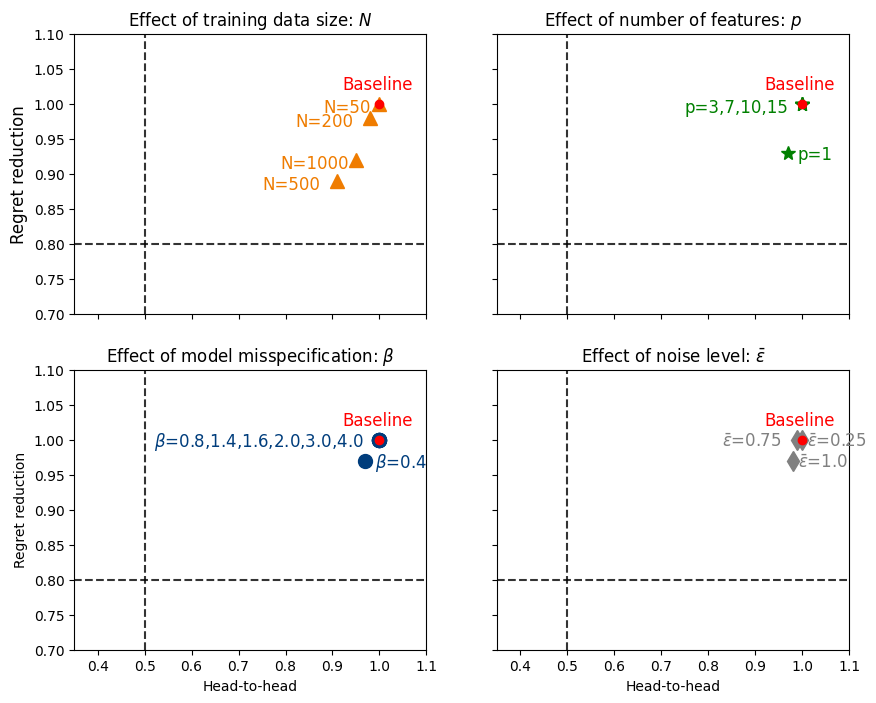

In [516]:
ms = 10 # marker size
fs = 12 # font size
ls = 12 # label size
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# # ---- 子图 1: N 的影响 ----
ax = axes[0]
N_indices = [0, 2, 3, 4]
for i in N_indices:
    ax.plot(h2h_N_ante[i], regret_N_ante[i], color='#EF7C00', marker='^', markersize = ms, linestyle='None')

ax.text(h2h_N_ante[0] - 0.12, regret_N_ante[0] - 0.012, f'N={num_train_all[0]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[2] - 0.16, regret_N_ante[2] - 0.012, f'N={num_train_all[2]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[3] - 0.16, regret_N_ante[3] - 0.012, f'N={num_train_all[3]}', color='#EF7C00', fontsize=fs)
ax.text(h2h_N_ante[4] - 0.16, regret_N_ante[4] - 0.012, f'N={num_train_all[4]}', color='#EF7C00', fontsize=fs)
# 单独标注 baseline
ax.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker='o', markersize = 6,linestyle='None')
ax.text(h2h_N_ante[1] - 0.08, regret_N_ante[1] + 0.02, 'Baseline', color='red',fontsize=fs)
ax.set_title('Effect of training data size: $N$',fontsize = ls)
ax.set_xlabel('Head-to-head',fontsize=ls)
ax.set_ylabel('Regret reduction',fontsize=ls)
# ax.grid(True)


# # ---- 子图 2: p 的影响 ----
ax = axes[1]
p_indices = [0, 1, 3, 4, 5]
ax.plot([h2h_P_ante[i] for i in p_indices], [regret_P_ante[i] for i in p_indices],
        color='green', marker='*',markersize = ms, linestyle='None', label='p')
ax.plot(h2h_P_ante[2], regret_P_ante[2],color='red', marker='o', markersize = 6,linestyle='None')
ax.text(h2h_P_ante[2] - 0.08, regret_P_ante[2] + 0.02, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_P_ante[p_indices[0]] + 0.02, regret_P_ante[p_indices[0]] - 0.01, f'p={num_feat_all[p_indices[0]]}', color='green',fontsize = fs)
ax.text(h2h_P_ante[p_indices[1]] - 0.25, regret_P_ante[p_indices[1]] - 0.012, 'p=3,7,10,15', color='green',fontsize = fs)
# ax.text(h2h_P_ante[p_indices[2]] + 0.02, regret_P_ante[p_indices[2]] - 0.01, f'p={num_feat_all[p_indices[2]]}', color='green',fontsize = fs)
# ax.text(h2h_P_ante[p_indices[3]] + 0.02, regret_P_ante[p_indices[3]] - 0.01, f'p={num_feat_all[p_indices[3]]}', color='green',fontsize = fs)
# ax.text(h2h_P_ante[p_indices[4]] - 0.04, regret_P_ante[p_indices[4]] - 0.06, f'p={num_feat_all[p_indices[4]]}', color='green',fontsize = fs)

ax.set_title('Effect of number of features: $p$')
ax.set_xlabel('Head-to-head', fontsize=fs)
ax.set_ylabel('Regret reduction', fontsize=fs)
# # ax.grid(True)

# # # ---- 子图 3: d 的影响 ----
ax = axes[2]
d_indices = [0, 2, 5, 6, 7, 8, 9]
for i in d_indices:
    ax.plot(h2h_d_ante[i], regret_d_ante[i], color='#003D7C', marker='o', markersize = ms,linestyle='None')
ax.plot(h2h_d_ante[3], regret_d_ante[3],color='red', marker='o', markersize = 6,linestyle='None')
ax.text(h2h_d_ante[3] - 0.08, regret_d_ante[3] + 0.02, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_d_ante[0] + 0.02, regret_d_ante[0] - 0.01, f'$\\beta$={deg_all[0]}', color='#003D7C',fontsize=fs)
# # # ax.text(h2h_d_ante[1] + 0.02, regret_d_ante[1] - 0.025, f'd={deg_all[1]}', color='#003D7C',fontsize=fs)
ax.text(h2h_d_ante[2] - 0.48, regret_d_ante[2] - 0.01, '$\\beta$=0.8,1.4,1.6,2.0,3.0,4.0', color='#003D7C',fontsize=fs)
# # # ax.text(h2h_d_ante[4] + 0.02, regret_d_ante[4] - 0.025, f'd={deg_all[4]}', color='#003D7C',fontsize=fs)
# ax.text(h2h_d_ante[5] - 0.11, regret_d_ante[5] - 0.02, f'd={deg_all[5]}', color='#003D7C',fontsize=fs)
# ax.text(h2h_d_ante[6] + 0.02, regret_d_ante[6] - 0.02, f'd={deg_all[6]}', color='#003D7C',fontsize=fs)
# ax.text(h2h_d_ante[7] + 0.02, regret_d_ante[7] - 0.02, f'd={deg_all[7]}', color='#003D7C',fontsize=fs)
# ax.text(h2h_d_ante[8] + 0.02, regret_d_ante[8] - 0.02, f'd={deg_all[8]}', color='#003D7C',fontsize=fs)
# ax.text(h2h_d_ante[9] - 0.11, regret_d_ante[9] - 0.01, f'd={deg_all[9]}', color='#003D7C',fontsize=fs)

ax.set_title('Effect of model misspecification: $\\beta$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)



# # # ---- 子图 4: α 的影响 ----
ax = axes[3]
alpha_indices = [0, 2, 3]
alpha_vals = [0.25, 0.75, 1.0]
for i, alpha in zip(alpha_indices, alpha_vals):
    ax.plot(h2h_e_ante[i], regret_e_ante[i], color='gray', marker='d', markersize = ms, linestyle='None')
ax.plot(h2h_e_ante[1], regret_e_ante[1],color='red', marker='o', markersize = 6,linestyle='None')
ax.text(h2h_e_ante[1] - 0.08, regret_e_ante[1] + 0.02, 'Baseline', color='red',fontsize=fs)

ax.text(h2h_e_ante[0] + 0.01, regret_e_ante[0] - 0.01, r'$\bar{\epsilon}$=0.25', color='gray',fontsize = fs)
ax.text(h2h_e_ante[2] - 0.16, regret_e_ante[2] - 0.01, r'$\bar{\epsilon}$=0.75', color='gray',fontsize = fs)
ax.text(h2h_e_ante[3] + 0.012, regret_e_ante[3] - 0.01, r'$\bar{\epsilon}$=1.0', color='gray',fontsize = fs)

ax.set_title('Effect of noise level: $\\bar{\epsilon}$')
ax.set_xlabel('Head-to-head')
ax.set_ylabel('Regret reduction')
# ax.grid(True)

# ---- 整体设置 ----
for ax in axes:
    ax.axvline(0.5, linestyle='dashed', alpha=0.8, color='k')
    ax.axhline(0.8, linestyle='dashed', alpha=0.8, color='k')
    ax.set_xlim(0.35, 1.1)
    ax.set_ylim(0.7, 1.1)
    ax.label_outer()

# plt.tight_layout()
fig.savefig(Result_dir + f'DDR_vs_SPO_diff_settings_ante_mu={mu}_lamb={lamb}_subfigures.pdf', format='pdf', bbox_inches="tight")
plt.show()
